# <div align="center">  <span style="color:blue">  <img src="../Dessins/Triangular.pdf" align="center" width="150" />  &emsp; Triangular Catalan Combinatorics</font></span> <div align="center"> <font size="5"> <span style="color:red"> *François Bergeron*</span> <span style="color:green"> (August 2023)</span>

The basic tools include symmetric function for triangular (and concave) partitions. There are two dictionnaries for precalculated values of the fonctions $$F_\tau(\boldsymbol{q};\boldsymbol{z})=\sum_{\mu\vdash n} c_{\lambda\mu} s_\lambda(\boldsymbol{q})\otimes e_{\overline{\mu}}(\boldsymbol{z}),$$ where $\overline{\mu}$ denotes the partition obtained by removing from $\mu$ its largest part; and (for more values) of $$A_\tau(\boldsymbol{q})=\langle F_\tau(\boldsymbol{q};\boldsymbol{z}),e_0(\boldsymbol{z})\rangle.$$

In [18]:
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [19]:
%display latex
%runfile ../tools/Tools_For_Symmetric_Functions.py
%runfile ../tools/Tools_For_Triangular_Partitions.py
%runfile ../tools/Ajouts_Classe_Partages.py
%runfile ../tools/Ajouts_Classe_Tenseurs.py
%runfile ../tools/F_Dict.py
%runfile ../tools/A_Dict.py
%runfile ../tools/E_Dominant_Dict.py
%runfile ../tools/Triangularity_Tests.py

@cached_function
def e_decontracte(F,n):
    return add(c*tensor([s(mu),s(e(nu)*e[n-nu.size()])])  
                  for (mu,nu),c in tensor([s,e])(F)).Pleth(Z-Integer(1))

def Bar(nu):
    if nu.length()==1:
        return zero
    else:
        return Partition(nu[1:])
    
@cached_function
def E_via_F(tau,n):
    tau=Partition(tau)
    if tau in Precalculated_F.keys():
        return e_decontracte(Precalculated_F[tau],n)
    elif tau.length()<=3:
        return E(tau,n)
    else:
        print((tau,'To be calculated'))
        return None
        
@cached_function
def F_via_E(tau):
    tau=Partition(tau)
    return (tensor([s,e])(E(tau,2*tau.length()).Pleth(Z+1))).bar()

@cached_function
def F(tau,n=None):
    if tau==None:
        return 0*tensor([Un,Un])
    else:
        tau=Partition(tau)
        if tau in Precalculated_F.keys() and n==None:
            return Precalculated_F[tau]
        elif tau in Precalculated_F.keys():
            return fixe_n(Precalculated_F[tau],n)
        elif tau.length()<=3 and tau[1]>1:
            return F_via_E(tau)
        else:
            print((tau,'To be calculated'))
            return None

        
@cached_function
def fixe_n(F,n):
    return tensor([s,e])(add(c*tensor([s(mu),s(e(nu)*e[n-nu.size()])])  
                  for (mu,nu),c in tensor([s,e])(F)))
        
@cached_function
def A(tau):
    tau=Partition(list(tau))
    if not Is_Dominant(tau):
        return A(tau.conjugate())
    elif tau in Precalculated_A.keys():
        return Precalculated_A[tau]
    elif tau in E_Dominant_Dict.keys():
        return E(tau,len(tau)+1).scalar(e[len(tau)+1])
    elif tau.length()<=1:
        return s[tau.size()]
    elif tau.length()==2:
        (a,b)=tau
        return add(s[a+b-2*d,d] for d in range(b+1) if 3*d<=a+b)
    elif tau.length()==3 and not tau.Moins((3,2,1))==None  and Est_Concave(tau):
        return A_v(part_to_vect(tau))+(A(tau.Moins((3,2,1)))*e[3]).restrict_partition_lengths(3)
    elif tau.length()==3 and Est_Concave(tau):
        return A_v(part_to_vect(tau))
    else:
        print((tau,'To be calculated or is not concave'))
        return None

@cached_function
def E(tau,n=None):
    tau=Partition(list(tau))
    if tau in E_Dominant_Dict.keys() and n==tau.length()+1 and tau.length()>3:
        return E_Dominant_Dict[tau]
    elif tau in Precalculated_F.keys():
        return E_via_F(tau,n)
    elif n==None:
        return E(tau,tau.length()+1)
    elif tau.length()==3 and tau[0]>2 and tau[1]>1 and Est_Concave(tau):
        return (Formal_Coefficients(E_v(part_to_vect(tau,n)))
                +(tensor([e[3],Un])*E(tau.nabla(power=-1),n)).restrict_length(3))
    else:
        return Formal_Coefficients(E_v(part_to_vect(tau,n)))



def e_bar(F):
    return add(c*e(Bar(nu)) for nu,c in e(F))

def e_debar(F,n):
    return add(c*e(nu)*e(nu)*e[n-nu.size()] for nu,c in e(F))

def F_skew(FF,n):
    return add(c*tensor([s(mu).skew_by(e[n]),e(nu)]) for (mu,nu),c in FF)

@cached_function
def Delta(g,f):
    if f==0:
        return 0
    else:
        return s(add(c*g(B_mu(mu)-1)*H(mu) for (mu,c) in H(f)))

@cached_function
def InvDelta(g,f):
    if f==0:
        return 0
    else:
        return s(add(c*(1/(g(B_mu(mu)-1)))*H(mu) for (mu,c) in H(f)))
    
def B_mu(mu):
    return add(q^(i-1)*t^(j-1) for (i,j) in Cellules(mu))

@cached_function
def BosFer(tau,n=None):
    if n==None:
        n=len(min_concave(tau))
    return E(tau,n).Eval(q+t-u-v).map_coefficients(lambda c:c.substitute({u:-u,v:-v}))
    
def Test_skew_Delta(tau,n):
    return all([E_via_F(tau,n).Eval(q+t)==(InvDelta(e[n-1-k],E_via_F(tau,n).skew_by(e[k]).Eval(q+t))).nabla() 
     for k in range(n)])

def Factor(g):
    if g==1 or g==0:
        return g
    else:
        return factor(g)
    
@cached_function   
def E_Complete(tau,n):
    return E(tau,n).oplus(add(tensor([A(tau).skew_by(e[k]),s([k+1]+[1 for i in range(n-k-1)])]) for k in range(n-1)))

def MinSupp(tau):
    return min([add((k+1)*mu[k] for k in range(mu.length())) for mu,c in A(tau)])

def MaxSupp(tau):
    return max([add((k+1)*mu[k] for k in range(mu.length())) for mu,c in A(tau)])

def A_HookPart(tau):
    tau=Partition(tau)
    n=min(tau.length(),tau[0])
    return add(c[0]*Sym(s([1+SR(c[1]).degree(SR(v))]+[1 for i in range(SR(c[1]).degree(SR(u)))])) 
               for c in (v^(tau.size()-binomial(n+1,2))*mul((u+v^k) for k in range(2,n+1))).numerator())

def Hooks_of_A(tau):
    return add(c*s(mu) for mu,c in A(tau) if mu.length()==1 or mu[1]==1)

def HookHookFormula(n):
    return add(q_binomial(n-1,k)*prod(q^i+t for i in range(1,n-k))*s(hook(n,n-1-k)) for k in range(n))

def Is_Hook(mu):
    return mu.length()<=1 or mu[1]==1

@cached_function
def HookHookPol(G):
    return G.restrict_support(Test=Is_Hook).Eval(q-t).map_coefficients(lambda c:(c.substitute({t:-t})))

@cached_function
def HookPol(G):
    return G.Eval(q-t).map_coefficients(lambda c:(c.substitute({t:-t})))

@cached_function
def Super_nabla_v(v,g,Formal=True):
    rep=add(c*lambda_mu_v(v,mu)*tensor([H(mu),H(mu)]) for (mu,c) in H(g))
    if Formal and not rep==0:
        return Formal_Symmetric(rep)
    else:
        return rep.To_b()
    
               
@cached_function
def PointCat(n,k=2):
    return plot(add(point((Integer(SR(a[1]).degree(q)-1),Integer(SR(a[1]).degree(t))),size=max(2,k*a[0]))
                   for a in (qt_catalan_number(n)*(q-t)).numerator() if a[0]>=0  and SR(a[1]).degree(t)>0))
    
def TableCoeff(F,g1=s,g2=s,Famille=Partitions):
    n=F.degree()
    f1=g1.dual_basis()
    f2=g2.dual_basis()
    return table([[(SR(var('mu')),SR(var('nu')))]
                  +[g1(alpha) for alpha in sorted(Famille(n))]]
                  +[[g2(beta)]+[F.scalar(f2(beta)).scalar(f1(alpha))
                              for alpha in sorted(Famille(n))] 
                    for beta in sorted(Famille(n))])


def Formal_Coefficients(F):
    return add(tensor([InSchur(c),s(nu)]) for nu,c in F)

def EPrintLatex(E):
    n=E.degree()
    Famille=Tous_Partages(n)
    First=true
    for mu in sorted(Famille):
        val=E.scalar(s(mu))
        if First and val.__len__()==1 and not val==0:
            print(latex(val),LatexExpr("\\otimes s_{"),latex(mu),LatexExpr("}"))
            First=false
        elif First and not val==0:
            print(LatexExpr("\\big("),latex(val),LatexExpr("\\big) \\otimes s_{"),latex(mu),LatexExpr("}"))
            First=false
        elif val.__len__()==1 and not val==0:
            print(LatexExpr("+"),latex(val),LatexExpr("\\otimes s_{"),latex(mu),LatexExpr("}"))
        elif not val==0:
            print(LatexExpr("+\\big("),
                 latex(val),LatexExpr("\\big) \\otimes s_{"),latex(mu),LatexExpr("}"))

@cached_function
def SymCat(n):
    return Sym(add(a[0]*Sym(s[SR(a[1]).degree(q)-1,SR(a[1]).degree(t)]) 
                   for a in (qt_catalan_number(n)*(q-t)).numerator() if a[0]>=0))

# <span style="color:blue"> <font size="5">  $\mu$-Dyck paths</span>

For any partition $\mu$, the set $\mathcal{D}_\mu:= \{\alpha \, |\, \alpha\subseteq \mu\}$ of <span style="color:blue">**$\mu$-Dyck paths**</span> is simply the set of partitions contained in $\mu$. For the $k$-staircases, $(k(n-1),\ldots,2k,k,0)$, the cardinalities of this sets is the Fu&szlig;-Catalan numbers. Other special cases include rational and rectangular Catalan situations. 

In [20]:
Dyck_tau((6,4,2)).cardinality()

55

#  <span style="color:blue">   <font size="5"> Determinental formula for $q$-enumeration</span>

The $q$-enumeration of partitions coantaining $\nu$ and contained in $\mu$:
$$C_{\mu/\nu}(q) =  \det\left(q^{\binom{j-i+1}{2} + (j-i+1)\nu_j} \binom{\mu_j-\nu_i+1}{j-i+1}_q\right),$$ 
See:
<a href="https://www.sciencedirect.com/science/article/pii/S0024379509004819"><span style="color:blue">*Note on enumeration of partitions 
contained in a given shape*</span></a> by Gessel and Loehr, in **Linear Algebra and its Applications**, Volume 432, Issues 2–3, 2010, Pages 583-585. 

Observing that $q^{\binom{k}{2}} \binom{n}{k}_q = e_k([n]_q)$, we may reformulate the above (when $\mu=0$), as:
\begin{align} C_{\mu}(q) 
&=  \det\left(q^{\binom{j-i+1}{2}} \binom{\mu_j+1}{j-i+1}_q\right)\\
&=  \det\left( e_{j-i+1}([\mu_j+1]_q) \right)_{1\leq i,j\leq \ell(\mu)}
\end{align}

We have the parking extension of this formula, with $\mu=(\mu_1,\ldots,\mu_\ell,\underbrace{0,\ldots,0}_{n-\ell})$:
\begin{align} \mathcal{P}_{\mu}(q;\boldsymbol{z}) &:=  \sum_{\alpha\subseteq \mu} q^{|\alpha|} s_{(\alpha+1^n)/\alpha}(\boldsymbol{z})\\
&= \det\left( h_{j-i+1}(\boldsymbol{z}\cdot\,[\mu_j+1]_q) \right)_{1\leq i,j\leq n}\\
&=\tiny{\left|  \begin{matrix}
h_1(\boldsymbol{z}\,h_{\mu_1}(1,q)) 
	& h_2(\boldsymbol{z}\,h_{\mu_2}(1,q)) & \ldots 
	&h_{n-1}(\boldsymbol{z}\,h_{\mu_{n-1}}(1,q))& h_n(\boldsymbol{z} \,h_{\mu_n}(1,q))\phantom{\quad }\\
1& h_1(\boldsymbol{z} \,h_{\mu_2}(1,q)) & \ldots &h_{n-2}(\boldsymbol{z} \,h_{\mu_{n-1}}(1,q))&h_{n-1}(\boldsymbol{z} \,h_{\mu_n}(1,q))\\
0& 1 & \ldots &h_{n-3}(\boldsymbol{z} \,h_{\mu_{n-1}}(1,q))&h_{n-2}(\boldsymbol{z} \,h_{\mu_n}(1,q))\\
\vdots& \vdots & \ddots &\vdots&\vdots\\
0& 0 & \ldots &1&h_{1}(\boldsymbol{z} \,h_{\mu_n}(1,q))\phantom{\quad }\\
\end{matrix} \right|}
\end{align}

Expression stabilize as $n$ becomes large enough. For instance, when $n\geq 5$,  
\begin{align}
\mathcal{P}_{(321,0^{n-3})}(q;\boldsymbol z)
&=(q^6\, e_{111}(\boldsymbol{z})
    +(q^4+2q^5)\,e_{21}(\boldsymbol{z})+q^3\,e_3(\boldsymbol{z}))\,e_{n-3}(\boldsymbol{z})\\
  &\qquad  
    +((q^5+q^4+q^3)\,e_{11}(\boldsymbol{z})
     +(q^4+q^2)\,e_{2}(\boldsymbol{z}))\, e_{n-2}(\boldsymbol{z})\\
   &\qquad  +(q^3+q^2+q)\, e_{1}(\boldsymbol{z})\,e_{n-1}(\boldsymbol{z})
    +  e_{n}(\boldsymbol{z})
\end{align}
The associated "dimension" is:
$$
\langle \mathcal{P}_{(321,0^{n-3})}(q;\boldsymbol z),p_1^6\rangle  = {\left(6 \, q^{6} + 6 \, q^{5} + 3 \, q^{4} + q^{3}\right)} \binom{n}{3} + {\left(2 \, q^{5} + 3 \, q^{4} + 2 \, q^{3} + q^{2}\right)} \binom{n}{2} + {\left(q^{3} + q^{2} + q\right)} \binom{n}{1} + \binom{n}{0}$$

For all $\mu$ dominant, padding with 0's to make $\mu$ and $\mu'$ be of same length, the difference $\mathcal{P}_{\mu'}(q,\boldsymbol{z})-\mathcal{P}_{\mu}(q,\boldsymbol{z})$ appears to be Schur positive.  

In [21]:
def q_int(n,k=0):
    if k==-1:
        return 1
    else:
    	return add(binomial(i+k,k)*q^i for i in range(n))


def ee(k,n):
    if k<0 or n<k:
        return 0
    else:
        return e[k](q_int(n))


def hkhnZ(k,n,j=1):
    if k<0 or n<=0:
        return 0*h[0]
    else:
        return h[k](h[n-1](j*q+1)*Z)

def hkhnZqt(k,n,j=1):
    if k<0 or n<=0:
        return 0*h[0]
    else:
        return h[k](h[n-1](q+t)*Z)
        
def hknZ(k,n):
    if k<0 or n<=0:
        return 0*h[0]
    else:
        return h[k](n*Z)
        
def hhz(k,n):
    if k<0:
        return 0
    else:
        return h[k](q_int(n)*Z)
        
@cached_function
def P_mu(mu,n=None,ff=hkhnZ):
    if n==None:
        n=len(mu)
    mu=tuple(mu)+tuple([0 for i in range(n-len(mu))])
    return det(matrix([[ ff(j-i+1,mu[j]+1) 
                                       for j in range(n)] 
                                      for i in range(n)]))
@cached_function
def C_lambda_mu(mu,nu=tuple([0]),q=q):
    mu=Partition(mu)
    nu=Partition(nu)
    s=mu.length()
    nu=list(nu)+[0 for i in range(s-nu.length())]
    return det(matrix([[q_binomial(mu[j]-nu[i]+1,j-i+1,q=q)*q**(binomial(j-i+1,2)+(j-i+1)*nu[j])
                                       for j in range(s)] 
                                      for i in range(s)]))
@cached_function
def q_Enumer_Dyck_mu(tau,x=q):
    tau=Partition(tau)
    return add(x**(Partition(mu).size()) for mu in Dyck_tau(tau))

@cached_function
def q_Enumer_Park_mu(tau,n=None,x=q):
    tau=Partition(tau)
    if n==None:
        n=tau.length()+1
    return s(add(x**(Partition(mu).size())*Sym_Park(mu,n) for mu in Dyck_tau(tau)))

@cached_function
def Sym_Park(mu,n):
    mu=Partition(mu)
    return e(s(mu.Plus(Partition([n]).conjugate())).skew_by(s(mu)))

def E_from_P(mu,n=None):
    mu=Partition(mu)
    return q^(mu.size())*P(mu,n).map_coefficients(lambda c:c.substitute({q:1/q}))

def N_lambda(mu):
    n=len(mu)
    return  factorial(n)*det(Mat_N_lambda(mu)) 

def Mat_N_lambda(mu):
    n=len(mu)
    def co(mu,i,j): 
        if i<=j+1: return (mu[n-i-1]+1)^(j-i+1)/factorial(j-i+1) 
        else: return 0
    return matrix([[co(mu,i,j) for j in range(n)] for i in range(n)]) 

@cached_function
def Mat_P(mu,n=None,ff=hkhnZ):
    if n==None:
        n=len(mu)+1
    mu=tuple(mu)+tuple([0 for i in range(n-len(mu))])
    return matrix([[ ff(j-i+1,mu[j]+1)  for j in range(n)]  for i in range(n)])

@cached_function
def Mat_C_mu(mu,nu=tuple([0]),q=q):
    mu=tuple(mu)
    nu=tuple([0])
    s=len(mu)
    nu=nu+tuple([0 for i in range(s-len(nu))])
    return (matrix([[q_binomial(mu[j]-nu[i]+1,j-i+1,q=q)*q**(binomial(j-i+1,2)+(j-i+1)*nu[j])
                                       for j in range(s)] 
                                      for i in range(s)]))

def coco(a,b):
    if a<0:
        return 0*tensor([s[0],s[0]])
    elif a==0:
        return tensor([s[0],s[0]])
    else:
        return tensor([s,s])(h[a](tensor([h[b](Z+1),h[1]])))

def Mcoco(mu):
    n=len(mu)
    return matrix([[ (coco(j-i+1,mu[j]))  for j in range(n)]  for i in range(n)])

def Detcoco(mu):
    return tensor([s,e])(det(Mcoco(mu)))

<img src="Textes/Generalization.png" width="300" height="300" />

In [22]:
def Stan(mu):
    n=len(mu)
    def f(i,j): 
        if j-i+1<0: return 0 
        else: return mu[n-1-i]^(j-i+1)/factorial(j-i+1)
    return factorial(n)*det(matrix([[f(i,j)
                           for j in range(n)] 
                          for i in range(n)]))

In [23]:
P_mu((3,2,1),5)==q_Enumer_Park_mu((3,2,1),5)

True

In [77]:
all([P_mu(mu,n)==q_Enumer_Park_mu(mu,n) for mu in Partitions(5) for n in range(6,8)])

True

In [24]:
@add_method(ClassePartages)
def moins(self,nu):
    nu=Partition(nu)
    a=self.length()
    b=nu.length()
    return Partition(sorted([self[j]-nu[j] for j in range(b)]+[self[j] for j in range(b,a)],reverse=True))
    
@cached_function
def Y_Enumer_Park_mu(tau,n=None,x=q):
    tau=Partition(tau)
    if n==None:
        n=tau.length()+Integer(1)
    return add(tensor([h(tau.moins(mu)),Sym_Park(mu,n)]) for mu in Dyck_tau(tau))

@cached_function
def Y_Enumer_Park_mu(tau,n=None,x=q):
    tau=Partition(tau)
    if n==None:
        n=tau.length()+Integer(1)
    return add(tensor([s(mu).omega(),Sym_Park(mu,n)]) for mu in Dyck_tau(tau))

#  <span style="color:blue">   <font size="5"> Subpartition Chains</span>

<img src="Textes/Exrcice149_Page443_StanleyEC1.png" width="400" height="400" />

In [25]:
def hkhnZ1(k,n,j=1,q=1):
    if k<0 or n<=0:
        return 0*h[0]
    else:
        return h[k](h[n-1](j*q+1)*Z)
        
@cached_function
def P_mu_r(mu,n=None,ff=hkhnZ1,r=1):
    if n==None:
        n=len(mu)
    mu=tuple(mu)+tuple([0 for i in range(n-len(mu))])
    return det(matrix([[ ff(j-i+r,mu[j]+r) 
                                       for j in range(n)] 
                                      for i in range(n)]))

def MultCat(k,n):
    if n<0:
        return 0
    else:
        return matrix([[Cat(k+j+i) for j in range(n)] for i in range(n)]).determinant()

@cached_function
def MultNab(k,n):
    return ((-1)^(n//2)*s[(n for i in range(n+k-1))]).nabla(t=1)

def Tnk(k,n):
    return mul(mul((i+j+2*n)/(i+j) for j in range(i,k)) for i in range(1,k))

def SubPartitions(mu):
    mu=Partition(mu)
    return Set([Partition(list(nu)) for k in range(mu.size()+1) for nu in Partitions(k, outer=mu)])

@cached_function
def Young(n):
    E=[mu for k in range(n+1) for mu in Partitions(k)]
    ord = lambda x,y: y.contains(x)
    return Poset((E,ord),facade=True)

def SubpartitionChainNumber(mu,k):
    mu=Partition(mu)
    n=mu.size()
    Yn=Young(n)
    return Yn.subposet(SubPartitions(mu)).zeta_polynomial().substitute({q:k+1})

In [26]:
%runfile ../tools/q_analogues.py

In [27]:
table([[P_mu_r(delta(n,n),n=n,r=r).scalar(e[r*n]) for n in range(1,6)] for r in range(1,5)])

\(1\),\(2\),\(5\),\(14\),\(42\)
\(1\),\(3\),\(14\),\(84\),\(594\)
\(1\),\(4\),\(30\),\(330\),\(4719\)
\(1\),\(5\),\(55\),\(1001\),\(26026\)


In [28]:
table([[factor(P_mu_r(delta(n,n),n=n,r=r).scalar(p[1]^(r*n))) for n in range(1,6)] for r in range(1,5)])

\(1\),\(3\),\(2^{4}\),\(5^{3}\),\(2^{4} \cdot 3^{4}\)
\(2^{2}\),\(2^{3} \cdot 3 \cdot 5\),\(2^{4} \cdot 3^{3} \cdot 5^{2}\),\(2^{5} \cdot 3^{3} \cdot 7^{4}\),\(2^{15} \cdot 3^{2} \cdot 7^{4}\)
\(3^{3}\),\(2^{4} \cdot 3^{3} \cdot 5 \cdot 7\),\(2^{11} \cdot 3^{4} \cdot 5 \cdot 7^{2}\),\(2^{11} \cdot 3^{10} \cdot 5 \cdot 7^{2} \cdot 11\),\(2^{15} \cdot 3^{10} \cdot 5^{5} \cdot 7 \cdot 11 \cdot 13\)
\(2^{8}\),\(2^{9} \cdot 3^{2} \cdot 5^{3} \cdot 7\),\(2^{13} \cdot 3^{5} \cdot 5^{5} \cdot 7 \cdot 11\),\(2^{15} \cdot 3^{5} \cdot 5^{5} \cdot 7^{2} \cdot 11^{4} \cdot 13\),\(2^{22} \cdot 3^{10} \cdot 5^{5} \cdot 7 \cdot 11^{4} \cdot 13 \cdot 17 \cdot 19\)


In [29]:
table([[(MultCat(k,n)) for k in range(7)] for n in range(7)])

\(1\),\(1\),\(1\),\(1\),\(1\),\(1\),\(1\)
\(1\),\(1\),\(2\),\(5\),\(14\),\(42\),\(132\)
\(1\),\(1\),\(3\),\(14\),\(84\),\(594\),\(4719\)
\(1\),\(1\),\(4\),\(30\),\(330\),\(4719\),\(81796\)
\(1\),\(1\),\(5\),\(55\),\(1001\),\(26026\),\(884884\)
\(1\),\(1\),\(6\),\(91\),\(2548\),\(111384\),\(6852768\)
\(1\),\(1\),\(7\),\(140\),\(5712\),\(395352\),\(41314284\)


In [30]:
table([[(Tnk(k,n)) for k in range(7)] for n in range(7)])

\(1\),\(1\),\(1\),\(1\),\(1\),\(1\),\(1\)
\(1\),\(1\),\(2\),\(5\),\(14\),\(42\),\(132\)
\(1\),\(1\),\(3\),\(14\),\(84\),\(594\),\(4719\)
\(1\),\(1\),\(4\),\(30\),\(330\),\(4719\),\(81796\)
\(1\),\(1\),\(5\),\(55\),\(1001\),\(26026\),\(884884\)
\(1\),\(1\),\(6\),\(91\),\(2548\),\(111384\),\(6852768\)
\(1\),\(1\),\(7\),\(140\),\(5712\),\(395352\),\(41314284\)


In [31]:
((-s[2,2,2,2,2]).nabla(t=1).scalar(e[10]))

q^21 + q^20 + 3*q^19 + 5*q^18 + 8*q^17 + 10*q^16 + 13*q^15 + 12*q^14 + 12*q^13 + 9*q^12 + 6*q^11 + 3*q^10 + q^9

In [32]:
@cached_function
def Catr(n,r):
    return e[n].nabla(t=1,power=r).scalar(e[n])

In [33]:
def MultCatr(k,n,r=1):
    if n<0:
        return 0
    else:
        return matrix([[Catr(k+j+i,r) for j in range(n)] for i in range(n)]).determinant()


In [34]:
MultCatr(5,1,r=2).substitute({q:1})

273

In [35]:
table([[SubpartitionChainNumber(delta(k,k),n) for k in range(7)] for n in range(7)])

\(1\),\(1\),\(1\),\(1\),\(1\),\(1\),\(1\)
\(1\),\(1\),\(2\),\(5\),\(14\),\(42\),\(132\)
\(1\),\(1\),\(3\),\(14\),\(84\),\(594\),\(4719\)
\(1\),\(1\),\(4\),\(30\),\(330\),\(4719\),\(81796\)
\(1\),\(1\),\(5\),\(55\),\(1001\),\(26026\),\(884884\)
\(1\),\(1\),\(6\),\(91\),\(2548\),\(111384\),\(6852768\)
\(1\),\(1\),\(7\),\(140\),\(5712\),\(395352\),\(41314284\)


In [36]:
table([[(SubpartitionChainNumber(delta(2*k,k),n)) for k in range(1,6)] for n in range(5)])

\(1\),\(1\),\(1\),\(1\),\(1\)
\(1\),\(3\),\(12\),\(55\),\(273\)
\(1\),\(6\),\(66\),\(1001\),\(18564\)
\(1\),\(10\),\(245\),\(9996\),\(569772\)
\(1\),\(15\),\(714\),\(67830\),\(10296594\)


In [37]:
table([[P_mu_r(delta(2*n,n),n=n,r=r).scalar(e[r*n]) for n in range(1,5)] for r in range(1,4)])

\(1\),\(3\),\(12\),\(55\)
\(1\),\(6\),\(66\),\(1001\)
\(1\),\(10\),\(245\),\(9996\)


#  <span style="color:blue">  <font size="5">  The operators $\nabla^\boldsymbol{v}$  and $\nabla^\boldsymbol{v}_{\tiny{\boldsymbol{Y}}}$ </span>
Let $\boldsymbol{v}$ be in $\mathbb{Z}^n$, and $\mu$ be a partition of length $n$ ($\mu$ may have zero parts, and these are considered in its length). For any Standard Young Tableau (SYT) $\theta$ of shape $\mu$, we consider the rational fraction 
$$\Omega_\theta(q,t):= \prod_{\theta_{c}>\theta_{d}}
        \frac{(z_c-z_d)^+ (z_c-qt\,z_d)^+}
                {  (z_c-t\,z_d)^+ (z_c-q\,z_d)^+}
   \prod_{\theta_{c}=\theta_{d}+1}\frac{z_c}{z_c-qt\,z_d}
    \prod_{d\neq (0,0)} \frac{1}{z_d-1}$$
with $c$ and $d$ running over cells of $\mu$; and where $z_c:=q^it^j$, if $c=(i,j)$. Here, the value of $\alpha^+$ is set to be $\alpha$, if $\alpha\neq 0$, and $1$ if $\alpha=0$. We further set $\omega_\theta^{\boldsymbol{v}}(q,t):=\prod_{c\in \mu}z_c^{{\boldsymbol{v}}(\theta_{ij})-1}$, and consider the Macdonald eigenoperator $\nabla^{\boldsymbol{v}}$, whose eigenvalue on $\widetilde{H}_\mu(q,t;\boldsymbol{z})$ is
   $$\lambda_\mu^{\boldsymbol{v}}(q,t):=\frac{\gamma_\mu^{\boldsymbol{v}}(q,t)}
                     {\gamma_\mu^{\boldsymbol{0}}(q,t)},
        \qquad {\rm with} \qquad
      \gamma_\mu^{\boldsymbol{v}}(q,t):=\sum_{\theta \in \mathrm{SYT}(\mu)}\omega_\theta^{\boldsymbol{v}}(q,t)\,  \Omega_\theta(q,t).$$
Thus $\nabla^{\boldsymbol{0}}={\mathrm{Id}}$. It may be shown that 
 $$e_n(\boldsymbol{z}) =\sum_{\mu\vdash n} \gamma_\mu^{\boldsymbol{0}}(q,t)\ \widetilde{H}_\mu(q,t;\boldsymbol{z}),$$
and
 $$\nabla(e_n(\boldsymbol{z})) =\sum_{\mu\vdash n} \gamma_\mu^{1^{n}}(q,t)\ \widetilde{H}_\mu(q,t;\boldsymbol{z}),$$
in other words we have $\nabla^{(1^{n})}=\nabla$, and it may be seen that $\nabla^{(1^{n})}\nabla^{\boldsymbol{v}}=\nabla^{(1^{n})+{\boldsymbol{v}}}$. In particular, we consider 
 $$\mathcal{E}_{\boldsymbol{v}}(q,t;\boldsymbol z):=\nabla^{\boldsymbol{v}}(e_n(\boldsymbol{z})) =\sum_{\mu\vdash \ell(v)}
     \gamma_\mu^{\boldsymbol{v}}(q,t)\, \widetilde{H}_\mu(q,t;\boldsymbol z).$$
Moreover, when $\boldsymbol{v}$ is the multiplicity vector of $\mu=(\mu_1,\ldots,\mu_\ell,\underbrace{0,\ldots,0}_{n-\ell})$, we also write $\mathcal{E}^{(n)}_{\mu}(q,t;\boldsymbol z)$ for $\mathcal{E}_{\boldsymbol{v}}(q,t;\boldsymbol z)$.

The above notations are extended to parameter free expressions, encoded with tensor products, and having the necessary desired properties.

**Conjecture** $\mathcal{E}^{(n)}_{\mu}(q,t;\boldsymbol z)$ is (Schur$\otimes$Schur)-positive, if and only if $(\mu_1,\ldots,\mu_\ell,\underbrace{0,\ldots,0}_{n-\ell})$ is concave.


In [38]:
def Oab(a,b,mu):
    return (e[3]^b*( (hh(a-b)-hh(a-b-2))*h[1] + (hh(a-b-2)- hh(a-b-1))*h[2] ))(B_mu(mu)*Un).scalar(Un)/B_mu(mu)

In [39]:
Nabla_tv((0,1,1,1),flip(P_mu((2,2,1),4)))==flip(P_mu((5,4,2),4))

True

In [40]:
for n in range(10):
    for mu in Partitions(n):
        if Is_Dominant(mu):
            n=len(min_concave(mu))
            if not Nabla_tv(part_to_vect(mu,n),e[n])==flip(P_mu(mu,n)):
                show(mu)

In [41]:
min_concave((2,2,1,1))

(2, 2, 1, 1, 0)

In [42]:
e(E_vt((0,1,1,1)))

q^6*e[4] + (q^5+q^4+2*q^3)*e[3, 1] + (q^4+q^2)*e[2, 2] + (q^3+2*q^2+3*q)*e[2, 1, 1] + e[1, 1, 1, 1]

In [43]:
s(E_v((0,1,1)))

s[3] + (q^2+q*t+t^2+q+t)*s[2, 1] + (q^3+q^2*t+q*t^2+t^3+q*t)*s[1, 1, 1]

In [44]:
TableCoeff(Super_nabla_v((1,1,0),e[3]))

"\(\left(\mu, \nu\right)\)",\(s_{111}\),\(s_{21}\),\(s_{3}\)
\(s_{111}\),\(s_{4} + s_{21}\),\(s_{3} + s_{2} + s_{11}\),\(s_{1}\)
\(s_{21}\),\(s_{3} + s_{2} + s_{11}\),\(s_{2} + 2 s_{1}\),\(\boldsymbol{1}\)
\(s_{3}\),\(s_{1}\),\(\boldsymbol{1}\),\(0\)


In [45]:
TableCoeff(Super_nabla_v((1,0,1),e[3]))

"\(\left(\mu, \nu\right)\)",\(s_{111}\),\(s_{21}\),\(s_{3}\)
\(s_{111}\),\(s_{5} + s_{31}\),\(s_{4} + s_{3} + s_{21}\),\(s_{2}\)
\(s_{21}\),\(s_{4} + s_{3} + s_{21}\),\(s_{3} + 2 s_{2} + s_{11}\),\(s_{1}\)
\(s_{3}\),\(s_{2}\),\(s_{1}\),\(0\)


In [46]:
TableCoeff(Super_nabla_v((0,0,1,0),e[4]))

"\(\left(\mu, \nu\right)\)",\(s_{1111}\),\(s_{211}\),\(s_{22}\),\(s_{31}\),\(s_{4}\)
\(s_{1111}\),\(s_{8} + s_{61} + s_{51} + s_{42}\),\(s_{7} + s_{6} + s_{5} + s_{51} + 2 s_{41} + s_{32} + s_{31}\),\(s_{6} + s_{4} + s_{41} + s_{31} + s_{22}\),\(s_{5} + s_{4} + s_{3} + s_{31} + s_{21}\),\(s_{2}\)
\(s_{211}\),\(s_{7} + s_{6} + s_{5} + s_{51} + 2 s_{41} + s_{32} + s_{31}\),\(s_{6} + 2 s_{5} + 3 s_{4} + s_{3} + s_{41} + 3 s_{31} + s_{22} + 2 s_{21}\),\(s_{5} + s_{4} + 2 s_{3} + s_{31} + 2 s_{21} + s_{11}\),\(s_{4} + 2 s_{3} + 2 s_{2} + s_{21} + s_{11}\),\(s_{1}\)
\(s_{22}\),\(s_{6} + s_{4} + s_{41} + s_{31} + s_{22}\),\(s_{5} + s_{4} + 2 s_{3} + s_{31} + 2 s_{21} + s_{11}\),\(s_{4} + 2 s_{2} + s_{21}\),\(s_{3} + s_{2} + s_{1} + s_{11}\),\(\boldsymbol{1}\)
\(s_{31}\),\(s_{5} + s_{4} + s_{3} + s_{31} + s_{21}\),\(s_{4} + 2 s_{3} + 2 s_{2} + s_{21} + s_{11}\),\(s_{3} + s_{2} + s_{1} + s_{11}\),\(s_{2} + s_{1}\),\(0\)
\(s_{4}\),\(s_{2}\),\(s_{1}\),\(\boldsymbol{1}\),\(0\),\(0\)


In [47]:
E((4,3,1),4).PP()

\big( s[8] + s[5, 1] + s[4, 2] + s[6, 1] + s[3, 1, 1] \big) \otimes s[1, 1, 1, 1]

\qquad +\  \big( s[5] + s[6] + s[7] + s[3, 1] + s[3, 2] + 2*s[4, 1] + s[5, 1] + s[2, 1, 1] \big) \otimes s[2, 1, 1]

\qquad +\  \big( s[4] + s[6] + s[3, 1] + s[2, 2] + s[4, 1] + s[1, 1, 1] \big) \otimes s[2, 2]

\qquad +\  \big( s[3] + s[4] + s[5] + s[2, 1] + s[3, 1] \big) \otimes s[3, 1]

\qquad +\  s[2] \otimes s[4]

In [50]:
%runfile ../tools/q_analogues.py

In [51]:
mu=Partition((4,3,2,1))
n=mu.length()+1
(E(mu,n).Eval(q+1/q)*q^(mu.size())).map_coefficients(to_q_fact)

q^10*s[5] + f_7*q^4/(f_3*f_4)*s[3, 2] + f_4*f_7*q^6/(f_2*f_3*f_6)*s[4, 1] + f_8*q^2/f_4^2*s[2, 2, 1] + f_4*f_8*q^3/(f_2^2*f_3*f_6)*s[3, 1, 1] + f_9*q/(f_3*f_6)*s[2, 1, 1, 1] + f_10/(f_5*f_6)*s[1, 1, 1, 1, 1]

In [52]:
mu=Partition((4,3,2,1))
n=mu.length()+1
q_int(6)*((E(mu,n).Eval(q+1/q)*q^(mu.size())))(Z/q_int(6))

s[1, 1, 1, 1, 1]

In [53]:
mu=delta(5,3)
n=mu.length()+1
p(E(mu,n).Eval(q+1/q)*q^(mu.size())).map_coefficients(to_qn)

1/6*q_5^2*p[1, 1, 1] + (-1/2*q_10/q_2)*p[2, 1] + 1/3*q_15/(q_3*q_5)*p[3]

In [54]:
a=5
b=3
mu=delta(5,3)
n=mu.length()+1
q_int(a)*((E(mu,n).Eval(q+1/q)*q^(mu.size())))(Z/q_int(a))

s[1, 1, 1]

# <span style="color:blue"><font size="5">  Concavity Conjecture</span>
$\nabla^{\boldsymbol{v}(\mu)}(e_n(\boldsymbol{z}))$ is $(q,t)$-Schur positive if and only if $\mu$ is concave.

In [55]:
def Est_Concave(mu):
    nu=vector(mu)+vector(1 for i in range(len(mu)))
    return Is_Concave(Partition(nu))

def Test_Concave_Conjecture(mu):
    return Is_Positive(Formal_Coefficients(Nabla_v(part_to_vect(mu,len(min_concave(mu))),e[len(min_concave(mu))])))

# <span style="color:blue"> <font size="5">    $\nu$-Tamari Posets &emsp; <img src="../Dessins/Tamari84.png" align="top" width="100" height="80" />
</span>

 These are pure polyhedral complexes

In [56]:
e(E((2,1,1),4).Eval(q+2))-Tamari_q_z((2,1,1),4)

q*e[3, 1] + (-q)*e[2, 2]

# <span style="color:blue"><font size="5">  Properties </span>
For $\mu=(\mu_1,\ldots,\mu_\ell,\underbrace{0,\ldots,0}_{n-\ell})$, we consider formal expressions
$\displaystyle \mathcal{E}_{\mu}:=\sum_{\mu\vdash n} \left(\sum_\lambda c_\lambda^\mu s_\lambda\right) \otimes s_\mu$ that are such that
1. (support) For $\tau$ triangular, $\langle s_\lambda\otimes s_{\mu}, \mathcal{E}_\tau\rangle \not= 0$  forces $$\sum_i \binom{\mu_i}{2} + \sum_k k\,\lambda_k \leq |\tau|,$$ and this is sharp. In other words, we have $c_\lambda^\mu\neq 0$  only if  $\omega(\lambda)\leq|\tau|-\eta(\mu)$ where $\eta(\mu):=\textstyle{\sum_i \binom{\mu_i}{2}}$, and $\deg(\textstyle{\sum_\lambda c_\lambda^\mu s_\lambda})=|\tau|-\eta(\mu)$;
2. (hooks in alternants) For $\tau$ triangular, writing $\mathcal{A}_\tau$ for $\langle \mathcal{E}_\tau, e_n(\boldsymbol{z})\rangle$, setting $k:=\min(\ell(\tau),\ell(\tau'))$, we have $$\frac{1}{u+w}\mathcal{A}_\tau[u-\varepsilon w]=u^{|\tau|-\binom{k+1}{2}}(u^2+w)\cdots (u^{k}+w)
;$$
3. For $\tau$ triangular and dominant, $$e_n^\perp \mathcal{E}_\tau = \mathcal{E}_{\tau-(n,\ldots,2,1)};$$
4. (hook components via skew) For all $a+\ell=n-1$ we have $$e_a^\perp \mathcal{A}_\mu =\langle \mathcal{E}_\mu, s_{(a\,|\,\ell)}\rangle;$$
5. If $\boldsymbol{v}$ is the *part-difference vector* of $\mu$, then $$\mathcal{E}_{\mu}(q+t;\boldsymbol z)=\nabla_{\boldsymbol{v}}(e_n(\boldsymbol{z}));$$
6. (Boson Fermion) For any $n$, we have $$ \mathcal{E}_\delta(q+t-\varepsilon(u+v);\boldsymbol{z})=\sum_{k=0}^{n-1} \Theta_{e_k[(\vert{u+v})\boldsymbol{z}]}(\nabla(e_k^\perp e_{n})) $$
where, the operator $\Theta_g f$ is defined as
     $$\Theta_g  := \Pi\, g^*\,\Pi^{-1},\qquad
        {\rm with}\qquad g^*(\boldsymbol{z}):=g[\boldsymbol{z}/(1-t)(1-q)] ,$$
and $\Pi$ stands for the Macdonald eigenoperator having eigenvalues  $\prod_{(i,j)\in\mu/(1)} (1 - q^it^j)$. 
7. (skew and delta) For $\tau$ triangular and dominant, and all $0\leq k<n$, we have $$\Delta_{e_{n-1-k}}  \mathcal{E}^{(n)}_\tau(q+t;\boldsymbol{z}) = \nabla( (e_k^\perp \mathcal{E}^{(n)}_\tau)(q+t;\boldsymbol{z}));$$ 
8. For all $\mu$, we have $$\mathcal{E}_\mu(q+1;\boldsymbol{z})=\mathcal{P}_{\mu}(q,\boldsymbol{z});$$
9. Padding them with 0's, to make both $\mu$ and $\mu'$ of same length, we have that $\mathcal{E}_{\mu'}-\mathcal{E}_\mu$ is (Schur$\,\otimes$ Schur)-positive.
10. For all $\ell$, we have the relation (implied by 4) $$\big({\sum_{k} (-1)^{k+\ell} {\textstyle \binom{k}{\ell}}} e_k\big)^\perp \mathcal{A}_\tau = 
\big\langle \mathcal{E}^{(n)}_\tau,\sum_{\ell(\nu)=\ell+1} f_{\nu} \big\rangle .$$
Indeed, observe that $\sum_{\ell(\nu)=\ell+1} f_{\nu}$ is a linear combination of hook-indexed Schur, namely: $$\sum_{\ell(\nu)=\ell+1} f_{\nu} = \sum_{k} (-1)^{k+\ell}  {\textstyle \binom{k}{\ell}} s_{(k\,|\, n-k-1)}.$$ We also have $e_n=\sum_{\nu\vdash n} f_\nu$, hence 

In [57]:
def OK_Support(tau,n=None):
    if n==None:
        n=len(tau)+1
    return all([max([0]+[w(nu) for nu,c in E(tau,n).scalar(s(mu))])<=add(tau)+1-mu[0]  for mu in Partitions(n)])

def OK_skew_Delta(tau,n):
    return all([Delta(e[n-1-k],E(tau,n).Eval(q+t))==E(tau,n).skew_by(e[k]).Eval(q+t).nabla()
     for k in range(n)])

def OK_skew_hook(tau,n):
    return all([A(tau).skew_by(e[k])==E(tau,n).scalar(s(hook(n,n-k-1)))
     for k in range(n)])

def OK_hook_alt(tau):
    tau=Partition(tau)
    k=len(tau)+1
    return (A(tau)(u-v).substitute({v:-v})/(u+v)==u^(tau.size()-binomial(k,2))*mul(u^j+v for j in range(2,k)))

def OK_scalar_f(tau):
    n=len(tau)+1
    return  all([(A(tau).skew_by(add((-1)^(k+l)*binomial(k,l)*e[k] for k in range(n)))
                  ==E(tau,n).scalar(add(f(nu) for nu in Partitions(n) if len(nu)==l+1))) for l in range(n)])

def OK_Schur_Schur(tau):
    tau=Partition(tau)
    if not Is_Dominant(tau):
        return OK_Schur_Schur(tau.conjugate())
    n=2*max(len(tau),len(tau.conjugate()))
    return Is_Positive(E_via_F(tau.conjugate(),n)-E_via_F(tau,n))

def OK_deg_mu(tau):
    return all([w(mu)<=deg_mu(tau,nu) for (mu,nu),c in E(tau,len(min_concave(tau)))])

def OK_Boson_Fermion(n):
    return BosFer(delta(n,n))==Psi(e[n])

def OK_skew_A_f(tau,n):
    return all([(A(tau).skew_by(add((-1)^(k+l)*binomial(k,l)*e[k] for k in range(n))) ==
                 E(tau,n).scalar(add(f(nu) for nu in Partitions(n,length=l+1)))) for l in range(n)])

### All tests

#  <span style="color:blue">  <font size="5">  Filtered Harmonic Modules for $\mathcal{E}_\tau$  </span>
    
For a triangular partition $\tau=0^{d_0}1^{d_1}2^{d_2}\cdots a^{d_a}\cdots k^{d_k}$, with $n=\sum_i d_i$, set 
$$\mathbb{V}_\tau:=\det \Big(\frac{x_i^a}{a!} \frac{\theta_i^j}{j!} \Big)_{{1\leq i\leq n} \atop (0\leq j\leq d_a)_{a}},$$
where the $\theta_i$'s are inert variables. We consider the smallest module, $\mathcal{M}_\tau$ containing $\mathbb{V}_\tau$ which is closed under derivation and polarization operators indexed by partitions that fit inside $\tau$. Here the $x_i=x_{1i}$ lie in the "first" set of variables $\boldsymbol{x}_1 = (x_{11},\ldots,x_{1n})$.
These are of the operators of form $E_{(\alpha,\boldsymbol{v})} = E_{(\alpha_1,v_1)}E_{(\alpha_2,v_2)} \cdots E_{(\alpha_k,v_k)}$, with $\alpha\subseteq \tau$. The components of $\boldsymbol{v}$ are pairs $(k,\ell)$ of distinct indices of variable sets $\boldsymbol{x}_k = (x_{k1},\ldots,x_{kn})$ and $\boldsymbol{x}_\ell=(x_{\ell 1},\dots, x_{\ell n})$, and $$E_{(a,(k,\ell))} := \sum_{i=1}^n x_{ki} \partial x_{\ell i}^a.$$
Recall that the closure under operators of this form, with all $a_i=1$, gives a $\mathrm{GL}_\infty$ representation. Hence the associated character is Schur positive (in the $\boldsymbol{q}$-variables). 
    
The conjecture is that $\mathcal{E}_\tau(\boldsymbol{q},\boldsymbol{z})$ appears as the $(\mathrm{GL}_\infty\times S_n)$-Frobenius character of the "top part" of  $\mathcal{M}_\tau$. More precisely, we have $$\mathcal{M}_\tau^{(n)}(\boldsymbol{q};\boldsymbol{z}) -\mathcal{D}^{*}\mathcal{M}_\tau^{(n)}(\boldsymbol{q};\boldsymbol{z})=\mathcal{E}_\tau^{(n)}(\boldsymbol{q};\boldsymbol{z})$$

In [ ]:
from sage.rings.polynomial.flatten import FlatteningMorphism

def Base(L):
    if L.is_empty():
        return L
    else:
        C,m=Sequence(L).coefficient_matrix()
        return Set(((C.row_space().basis_matrix())*m).list())

def irred_idemp(nu):
    nu=Partition(nu)
    n=nu.size()
    Sn=SymmetricGroup(n)
    QSn=SymmetricGroupAlgebra(Rqtuv, n)
    return 1/factorial(n)*add(s(nu).scalar(p(sigma.cycle_type()))*QSn(sigma) for sigma in Sn.list())

def Orbit(pol,n):
    return Set([action(sigma,pol,n) for sigma in Sn.list()])

def Projection(L,nu):
    nu=Partition(nu)
    n=nu.size()
    return Base(Set([Diagact(irred_idemp(nu),pol,n) for pol in L]))

def action(sigma,pol,n):
    Sn=SymmetricGroup(n)
    QSn=SymmetricGroupAlgebra(Rqtuv, n)
    return pol.substitute({X[j][i]:X[j][sigma(i+1)-1]
                           for j in range(n) 
                           for i in range(n)}|{T[i]:T[sigma(i+1)-1]
                                               for i in range(n)})

def Diagact(id_mu,pol,n):
    Sn=SymmetricGroup(n)
    QSn=SymmetricGroupAlgebra(Rqtuv, n)
    return add(Rv(c)*action(sigma,pol,n) for sigma,c in id_mu)

@cached_function
def X_component_Diag(Diag,k):
    n=len(Diag)
    d=add(a for (a,b) in Diag)
    if k>d:
        return Set([])
    elif k==d:
        return Set([Delta_Diag(Diag)])
    else:
        return Base(Set([pol.derivative(X[0][i]) 
                             for i in range(n) 
                             for pol in X_component_Diag(Diag,k+1)]))

def Diag_tau(tau,n):
    L=[(k,list(tau).count(k)) for k in sorted(Set(tau),reverse=True)]+[(0,n-len(tau))]
    return tuple([(a,j) for (a,b) in L for j in range(b)])

def Delta_Diag(Diag):
    n=len(Diag)
    return Rv(det(matrix([[X[0][i]**a/factorial(a)*T[i]**b/factorial(b) 
                            for (a,b) in Diag] for i in range(n)])))

def Delta_tau(tau,n):
    return Delta_Diag(Diag_tau(tau,n))

@cached_function
def X_component(tau,k):
    return X_component_Diag(Diag_tau(tau,n),k)

@cached_function
def Frobenius(L,n):
    if L.is_empty():
        return 0
    else:
        return add(Projection(L,nu).cardinality()/(s(nu).scalar(p[1]^n))*s(nu) for nu in Partitions(n))

@cached_function
def Frob_Alt(L,n):
    if L.is_empty():
        return 0
    else:
        nu=Partition([n]).conjugate()
        return Projection(L,nu).cardinality()/(s(nu).scalar(p[1]^n))


@cached_function
def Irred_X_component(tau,mu,k):
    V=X_component(tau,k)
    return Projection(V,mu)

@cached_function
def Irred_X_component_Diag(Diag,mu,k):
    V=X_component_Diag(Diag,k)
    return Projection(V,mu)


@cached_function
def MX_module(tau,n):
    return add(q^k*Frobenius(Irred_X_component(tau,mu,k),n) 
               for mu in Partitions(n) 
               for k in range(add(tau)+1))

@cached_function
def MX_module_Diag(Diag):
    n=len(Diag)
    d=add(a for (a,b) in Diag)
    return add(q^k*Frobenius(Irred_X_component_Diag(Diag,mu,k),n) 
               for mu in Partitions(n) 
               for k in range(d+1))

n=10
Qtheta=PolynomialRing(QQ,n,var_array=['theta'])
Rtheta=FractionField(Qtheta)
Rxyz=PolynomialRing(Qtheta,n,n,var_array=['x'])
Rxyz.inject_variables(verbose=False)
X=Family({i:Rxyz.gens()[n*i:n*(i+1)] for i in range(n)})
Phi=FlatteningMorphism(Rxyz)
Rv=Phi(X[0][1]).parent()
Rv.inject_variables(verbose=False)
X=Family({i:Rv.gens()[n*(i+1):n*(i+2)] for i in range(n)})
T=Rv.gens()[:n]

Sn=SymmetricGroup(n)
QSn=SymmetricGroupAlgebra(Rqtuv, n)

def DD(g,j=1,U=X[0]):
    n=len(X[0])
    if j==0:
        return g
    else:
        return Rv(add(g.derivative(U[i],j) for i in range(n)))

@cached_function
def DDX_module_Diag(Diag):
    n=len(Diag)
    d=add(a for (a,b) in Diag)
    l=max(a for (a,b) in Diag)
    return add(q^k*Frobenius(Base(Set([DD(pol,j=i) 
                                       for i in range(1,l+1) 
                                       for pol in Irred_X_component_Diag(Diag,mu,k+i)])),n) 
               for mu in Partitions(n)
               for k in range(d+1))
    
@cached_function
def DDX_module(tau,n):
    return add(q^k*Frobenius(Base(Set([DD(pol,j=i) 
                                       for i in range(1,max(tau)+1) 
                                       for pol in Irred_X_component(tau,mu,k+i)])),n) 
               for mu in Partitions(n)
               for k in range(add(tau)+1))

### Développement en terme de Flip

In [ ]:
@cached_function
def Trivial_X_component_Diag(Diag):
    d=add(a for (a,b) in Diag)
    n=len(Diag)
    return Set([pol for k in range(d+1) for pol in Irred_X_component_Diag(Diag,Partition([n]),k)]) 

@cached_function
def Alt_X_component_Diag(Diag):
    d=add(a for (a,b) in Diag)
    n=len(Diag)
    return Set([pol for k in range(d+1) for pol in Irred_X_component_Diag(Diag,Partition([n]).conjugate(),k)]) 

def Delivative(Del,pol):
    return add(c[0]*DerMon(c[1],pol) for c in Del).numerator()

def DerMon(mon,pol):
    rep=pol
    for v in mon.variables():
        if not v in T:
            rep=rep.derivative(v,mon.degree(v))
    return rep

def Flip(Diag1,Diag2):
    return Delivative(Delta_Diag(Diag1),Delta_Diag(Diag2))

def ListFlip(DDD,Diag):
    return Base(Set([Flip(DD,Diag) for DD in DDD]))

In [ ]:
@add_method(Diagram([(0,0)]).__class__)
def diagram(self,col='green'):
    pp=plot(grid(self.number_of_cols(),self.number_of_rows())
             +add(carre((c[1]+1,c[0]+1),col=col) for c in self.cells()))
    pp.axes(show=False)
    return pp

@add_method(Diagram([(0,0)]).__class__)
def conjugate(self):
    return Diagram([(c[1],c[0]) for c in self.cells()])

def DiagLatex(Diag):
    pp=Diagram(Diag).diagram()
    return pp.show(figsize=2)

Diagram._latex_= DiagLatex



### Action et antisymétriseurs

In [ ]:
def Support(pol):
    V=pol.variables()
    return tuple([i for i in range(n) if X[0][i] in V or T[i] in V])
    
def Action(sigma,pol,A):
    return pol.substitute({X[0][i]:X[0][sigma(i)]
                           for i in A}|{T[i]:T[sigma(i)] for i in A})
def Antisymmetrizer(pol,A=None):
    if A==None:
        A=Set(Support(pol))
    SA=SymmetricGroup(A)
    n=A.cardinality()
    return 1/factorial(n)*add(sigma.sign()*Action(sigma,pol,A) for sigma in SA)

def Symmetrizer(pol,A=None):
    if A==None:
        A=Set(Support(pol))
    SA=SymmetricGroup(A)
    n=A.cardinality()
    return 1/factorial(n)*add(Action(sigma,pol,A) for sigma in SA)

def Is_Antisymmetric(pol):
    return pol==Antisymmetrizer(pol)

def Is_Symmetric(pol):
    return pol==Symmetrizer(pol)


### Codage des alternants par des monômes (diagrammes)

In [ ]:
def Pol_to_Diags(pol):
    return Set([tuple(sorted([(mon.degree(X[0][i]),mon.degree(T[i])) for i in Support(pol)])) for (c,mon) in pol])

def Diag_to_Mon(DD):
    return mul(X[0][i]^DD[i][0] * T[i]^DD[i][1] for i in range(len(DD)))
    
def Alt_Monomial_Encoding(pol):
    pol=Rv(pol.numerator())
    if Is_Antisymmetric(pol):
        Diags=Pol_to_Diags(pol)
        return add(c*mon for (c,mon) in pol if mon in Set([Diag_to_Mon(DD) for DD in Diags]))
    else:
        return 0
        

def Sym_Monomial_Encoding(pol):
    pol=Rv(pol.numerator())
    if Is_Symmetric(pol):
        Diags=Pol_to_Diags(pol)
        return add(c*mon for (c,mon) in pol if mon in Set([Diag_to_Mon(DD) for DD in Diags]))
    else:
        return 0

In [ ]:
Diag2=((4,0),(2,1),(1,2),(0,3))
for pol in Trivial_X_component_Diag(Diag2):
    show(Sym_Monomial_Encoding(pol))

In [ ]:
Alt_Monomial_Encoding(Delta_Diag(Diag2))/Diag_to_Mon(sorted(((3,0),(2,0),(1,0),(0,0))))

In [ ]:
Diag2=((4,0),(2,1),(1,2),(0,3))
ListFlip([sorted(((3,0),(2,0),(1,0),(0,0))),
          sorted(((4,0),(2,0),(1,0),(0,0)))],Diag2)==Trivial_X_component_Diag(Diag2)

In [ ]:
Diag_to_Mon(sorted(((3,0),(2,0),(1,0),(0,0))))

# <span style="color:blue">  <font size="5">  Polarization closure  </span>

In [ ]:
def Pol(k,g,a,b,n):
    if k==0:
        return g
    else:
        return add(X[a][i]*g.derivative(X[b][i],k) for i in range(n))

def ei(i,n):
    return vector([0 for k in range(i)]+[1]+[0 for k in range(n-i-1)])

def min_non_nul(v):
    v=vector(v)
    return min([v.length()-1]+[i-1 for i in range(v.length()) if max(v[i:])==0])

In [ ]:
@cached_function
def GradedFrobenius(tau,n):
    V=(q,t,u,v)   
    return add(mul(V[i]^deg[i] for i in range(len(deg)))*Frobenius(Polarized_Closure(tau,deg),n) 
               for deg in AllDeg(add(tau),len(tau)))

def AllDeg(d,l):
    if l==1:
        return [vector([i]) for i in range(d+1)]
    else:
        return [vector([i]+v.list()) for v in AllDeg(d,l-1) for i in range(d-add(v)+1)]
    
@cached_function
def GradedAlt(tau,n):
    return InSchur(GradedFrobenius(tau,n).scalar(e[n]))

In [ ]:
@cached_function
def GradedFrobenius(tau,n):
    V=(q,t,u,v)   
    return add(mul(V[i]^deg[i] for i in range(len(deg)))*Frobenius(Polarized_Closure_mu(tau,mu,deg),n) 
               for mu in Partitions(n)
               for deg in AllDeg(add(tau),len(tau)))

In [ ]:
@cached_function
def Polarized_Closure_mu(tau,mu,deg):
    deg=vector(deg)
    dtau=add(tau)
    l=len(deg)
    if min(deg)<0 or max(deg)>dtau:
        return Set([])
    elif min_non_nul(deg)<=0:
        return Irred_X_component(tau,mu,deg[0])
    else:
        a=min_non_nul(deg)
        v=deg-ei(a,l)
        return Base(Set([Pol(k,pol,a,b,n)
                         for b in range(a) for k in range(1,max(tau)+1)
                         for pol in Polarized_Closure_mu(tau,mu,v+k*ei(b,l))])
                   )



In [ ]:
@cached_function
def Polarized_Closure_mu(tau,mu,deg):
    deg=vector(deg)
    dtau=add(tau)
    l=len(deg)
    if min(deg)<0 or max(deg)>dtau:
        return Set([])
    elif min_non_nul(deg)<=0:
        return Irred_X_component(tau,mu,deg[0])
    else:
        a=min_non_nul(deg)
        v=deg-ei(a,l)
        return Base(Set([Pol(k,pol,a,b,n)
                         for b in range(a) for k in range(1,max(tau)+1)
                         for pol in Polarized_Closure_mu(tau,mu,v+k*ei(b,l))]))


In [ ]:
SR(mul(1/(1-q^i*t) for i in range(2,5))).series(q,8)

#  <span style="color:blue">  <font size="5">  Hook-Hook Components  </span>
For $\delta=(n,\ldots,2,1,0)$, we have the formula: $$\frac{1}{u+v}\mathcal{E}_\delta(q-\varepsilon t;u-\varepsilon v)=\sum_{a+\ell=n} (t;q)_\ell\, \textstyle{\binom{n}{\ell}_q}\, u^av^\ell,$$ where $(t;q)_\ell:=\textstyle{\prod_{i=1}^\ell q^i+t}$. Recall that $$\frac{1}{u+v}s_\mu(u-\varepsilon v) =\begin{cases} u^av^\ell, & \textrm{if}\ \mu=(a\,|\,\ell),\\ 0,&\textrm{otherwise}.\end{cases}$$

 

Furthermore, for $k>1$, we have $$\frac{1}{u+v}\mathcal{E}_{k\delta}(q-\varepsilon t;u-\varepsilon v) = q^{(k-1)\binom{n+1}{2}}(t;q)_n (u/v;q)_n v^n.$$ 

In [ ]:
@cached_function
def HookHook(tau,n=None):
    if n==None:
        n=len(tau)+1
    return Factor(1/(u+v)*(E(tau,n).Eval(q-t))(u-v).substitute({t:-t,v:-v}))

    
def MaxComp(c):
    d=c.numerator().degrees()[1]
    return qfact(d)*c.numerator().coefficient({t:d})

def MaxCompCompact(c):
    d=c.numerator().degrees()[1]
    return t^d*c.numerator().coefficient({t:d})

def qfact(n):
    return mul(q^k+t for k in range(1,n+1))

def CompHook(F):
    return add(s(mu)*MaxComp(c) for mu,c in F).map_coefficients(Factor)

def CompHookCompact(F):
    return add(s(mu)*MaxCompCompact(c) for mu,c in F).map_coefficients(Factor)

def DeCompHookCompact(F):
    if F==0:
        return 0
    else:
        show(CompHookCompact(F))
        DeCompHookCompact(F-CompHook(F))

def DeCompHook(F):
    if F==0:
        return 0
    else:
        show(CompHook(F))
        DeCompHook(F-CompHook(F))

def HookHookComp(tau):
    tau=Partition(tau)
    if not Is_Triangular(tau):
        return 'Not Triangular'
    elif not Is_Dominant(tau):
        return HookHookComp(tau.conjugate())
    else:
        return DeCompHookCompact(HookHookPol(E(tau,len(tau)+1)))


#  <span style="color:blue">  <font size="5">  Boson-Fermion specialization </span>

In [ ]:
def Pi_mu(mu):
    mu=Partition(mu)
    return mul(1-q^j*t^i for (i,j) in mu.cells() if not (i,j)==(0,0))

@cached_function
def Psi(f):
    n=f.degree()
    return add(Theta(e[k]((u+v)*Z),(f.skew_by(e[k])).nabla()) for k in range(n))

In [ ]:
Psi(e[3])

#    <span style="color:blue">  <font size="5">  Differences along poset covers, and around faces </span>
When $\tau\succeq \mu$ in the triangular lattice, we have ${\mathcal{A}_\tau}-{\mathcal{A}_\mu^+}$ Schur positive. Here, ${g^+}$ means that we add $1$ to the first part of partitions occuring in the Schur expansion of $g$. Likewise, we write $\mathcal{E}^+_\mu$ for the effect of the same transformation on first components of tensors; and we have a similar positivity for the analoguous difference (having same sizes for second components).

In [ ]:
def TriangularSuccessors(tau):
    tau=Partition(tau)
    n=tau.size()
    return Set([Partition(list(tau.add_cell(c[0])))
                       for c in tau.addable_cells()
                       if Is_Triangular(tau.add_cell(c[0]))])

def TriangularPredecessors(tau):
    tau=Partition(tau)
    n=tau.size()
    return Set([Partition(list(tau.remove_cell(c[0])))
                       for c in tau.removable_cells()
                       if Is_Triangular(tau.remove_cell(c[0]))])

def prime(mu,k=1):
    if len(mu)==0:
        return Partition([0])
    elif len(mu)==1:
        Partition([max([0,mu[0]-k])])
    elif mu[0]>=mu[1]+k: 
        return Partition([mu[0]-k]+mu[1:])
    else:
        return Partition([0])

def coprime(mu,k=1):
    if len(mu)==0:
        return Partition([k])
    else:
        return Partition([mu[0]+k]+mu[1:])

@cached_function
def CoPrime(g,n=1):
    if n==0:
        return g
    else:
        return add(c*s(coprime(mu,n)) for mu,c in g)

@cached_function
def Prime(g,n=1):
    if n==0:
        return g
    else:
        return add(c*s(prime(mu,n)) 
                   for mu,c in g 
                   if (not len(mu)==0) 
                   or (len(mu)==1 and mu[0]>=n) 
                   or (mu[0]>mu[1]+n))

@cached_function
def CoPrimeTens(F,n=1):
    if n==0:
        return F
    else:
        return add(c*tensor([s(coprime(mu,n)),s(nu)]) for (mu,nu),c in F)


@cached_function
def A_Face(tau):
    tau=Partition(tau)
    if tau.length()==0:
        return A(tau)
    else:
        return add((-1)^(tau.size()-mu.size())*CoPrime(A(mu),tau.size()-mu.size()) for mu in Face(tau))

@cached_function
def A_Face_P(tau):
    tau=Partition(tau)
    if tau.length()==0:
        return 0
    else:
        n=len(Diagonale(tau))
        return add((-1)^(n-tau.size()+mu.size())*Prime(A(mu),n-tau.size()+mu.size()) for mu in Face(tau))

@cached_function
def A_arrete(mu,tau):
    return A(tau)-CoPrime(A(mu))

@cached_function
def E_arrete(mu,tau,n=None):
    if n==None:
        n=len(tau)+1
    return E(tau,n)-CoPrimeTens(E(mu,n))

def A_chain(C):
    n=len(C)
    return CoPrime(A(C[0]),n-1)+add(CoPrime(A_arrete(C[i-1],C[i]),n-i-1) for i in range(1,n))

def A_chain_weights(C):
    n=len(C)
    return [CoPrime(A(C[0]),n-1)]+[CoPrime(A_arrete(C[i-1],C[i]),n-i-1) for i in range(1,n)]
    
def All_Chains(tau):
    tau=Partition(tau)
    n=tau.size()
    return Set([C for C in Young_Triangle(n).maximal_chains() if C[-1]==tau])

In [ ]:
def No_Zero(L):
    return tuple([c for c in L if not c==0])

In [ ]:
for C in Set([No_Zero(A_chain_weights(C)) for C in All_Chains((4,3,2,1))]):
    show(C)

In [ ]:
Set([No_Zero(A_chain_weights(C)) for C in All_Chains((5,3,2,1))])[2]

In [ ]:
#@cached_function
def Comprime(g,n=1):
    if n==0:
        return g
    else:
        return add(c*comprime(mu,n) for mu,c in g)

def comprime(mu,k):
    mu==Partition(mu)
    if k in Set([c[0]+1 for c in mu.removable_cells()]):
        return s(mu.remove_cell(k-1))
    else:
        return 0

#  <span style="color:blue">  <font size="5">  Immanants </span>

In [ ]:
def GenImm(A,v=1):
    n=A.dimensions()[0]
    Sn=SymmetricGroup(n)
    rep=add(tensor([mul(A[i-1,sigma(i+1)-1] for i in range(n)),s(p(sigma.cycle_type()))]) 
               for sigma in Sn)
    return -add((-1)^(nu.length())*c.substitute({q:v})*tensor([s(mu),s(nu)]) for (mu,nu),c in rep)

def Grass(k,n):
    if k==0 or n==0:
        return Partition([0])
    return Partition([k for i in range(n)])

def CharacGrassDet(k,n):
    return e[n](q_int(k+1)*Z)

def CharacGrassPerm(k,n):
    return (add(factorial(mu.length())/mul(factorial(j) for j in mu.to_exp())*h(mu) for mu in Partitions(n)))(q_int(k+1)*Z)

In [ ]:
N=5
all([GenImm(Mat_P(Grass(k,n),n),v=q).scalar(e[n])==CharacGrassDet(k,n) for n in range(1,N) for k in range(1,N)])

In [ ]:
all([GenImm(Mat_P(Grass(k,n),n),v=q).scalar(s[n])==CharacGrassPerm(k,n) for k in range(1,N) for n in range(1,N)])

In [ ]:
n=4
k=2
GenImm(Mat_P(Grass(k,n),n),v=q)

#  <span style="color:blue">  <font size="5">  Ordered partitions </span>

Permanent for the case of Grassmaniann

In [ ]:
k=2
n=3
GenImm(Mat_P(Grass(k,n),n).apply_map(lambda c:c(Z/q_int(3)))).PP()

In [ ]:
print([add(factorial(mu.length())/mul(factorial(j) 
                                for j in mu.to_exp())*h(mu) 
     for mu in Partitions(n)).scalar(p[1]^n) for n in range(1,7)])

In [ ]:
[e((n+1)*GenImm(Mat_P(delta(n,n),n)).scalar(e[n])(Z/(n+1))) for n in range(1,7)]

In [ ]:
table([(n,e(GenImm(Mat_P(delta(n,n),n),v=0).scalar(e[n]))) for n in range(1,7)])

Voir https://oeis.org/A171792

In [ ]:
table([(n,h(GenImm(Mat_P(delta(n,n),n)).scalar(s[n]))) for n in range(1,7)])

In [ ]:
table([(n,h(GenImm(Mat_P(delta(n,n),n),v=0).scalar(s[n])(Z*n))) for n in range(1,7)])

In [ ]:
@cached_function
def P_dim(mu,n=None):
    if n==None:
        n=len(mu)+1
    def ff(k,n):
        if k<0 or n<=0:
            return 0
        else:
            return add(q^j for j in range(n))^k/factorial(k)
    mu=tuple(mu)+tuple([0 for i in range(n-len(mu))])
    return factorial(n)*det(matrix([[ ff(j-i+1,mu[j]+1)  for j in range(n)]  for i in range(n)]))

In [ ]:
P_dim((2,2,1),4).substitute({q:1})

In [ ]:
P_mu((2,2,1,0)).scalar(p[1]^4).substitute({q:1})

#  <span style="color:blue">  <font size="5">  Triangular Permutations, via RSK </span>

In [ ]:
from sage.combinat.tableau import from_chain

Permutation._latex_= compact

@cached_function
def Young_Triangle_cond(n,condition=(lambda tau:True)):
    E=[nu for k in range(n+1) for nu in TriangularPartitions(k) if condition(nu)]
    R=[(mu,nu) for k in range(1,n+1) for mu in TriangularPartitions(k-1) if condition(mu)
       for nu in TriangularPartitions(k) if condition(nu) and nu.contains(mu)]
    return Poset([E,R],cover_relations=True)

@cached_function
def MaxChains(tau,condition=(lambda tau:True)):
    tau=Partition(tau)
    n=tau.size()
    Yn=Young_Triangle_cond(n,condition=condition)
    return Set((Yn.subposet(Set(Yn.interval(zero,tau)))).maximal_chains())

@cached_function
def MaxChainsTab(tau,condition=(lambda tau:True)):
    tau=Partition(tau)
    return Set([from_chain(c) for c in MaxChains(tau,condition=condition) if TestChaine(c)])

@cached_function
def RSK_Perm(tau,condition=(lambda tau:True)):
    return Set([Permutation(RSK_inverse(P,Q)[1]) 
                for P in MaxChainsTab(tau,condition=condition) 
                for Q in MaxChainsTab(tau,condition=condition)])

@cached_function
def RSK_Triangular_Perms(n,condition=(lambda tau:True)):
    return Set([sigma for tau in TriangularPartitions(n) if condition(tau) for sigma in RSK_Perm(tau,condition=condition)])


def TestChaine(c):  # Pour des chaines de pentes compatibles
    return max([Cone(c[i])[0] for i in range(len(c))])<min([Cone(c[i])[1] for i in range(len(c))])

def TestChaine(c):
    return True

In [ ]:
print([RSK_Triangular_Perms(n).cardinality() for n in range(7)])

In [ ]:
RSK_Triangular_Perms(4)

In [ ]:
[MaxChainsTab(tau).cardinality() for tau in TriangularPartitions(6)]

In [ ]:
[MaxChainsTab(tau).cardinality() for tau in TriangularPartitions(7)]

In [ ]:
[MaxChainsTab(tau).cardinality() for tau in TriangularPartitions(8)]

In [ ]:
[MaxChainsTab(tau).cardinality() for tau in TriangularPartitions(9)]

In [ ]:
part_to_vect((7,4,3,1,1))

In [ ]:
A_mu((7,4,3,1,1))(q+t)

In [ ]:
A_mu((7,4,3,1,1))

In [ ]:
mu=Partition((7,4,3,1,1))
part_to_vect(mu,len(min_concave(mu)))

In [ ]:
Test_Concave_Conjecture(mu)

# <span style="color:blue">  <font size="5">  Schur expansion support </span>
<img src="Dessins/seizeregion.pdf" align="center" width="400" /> <img src="Dessins/dixhuitregion.pdf" align="center" width="400" /> 

In [58]:
table([[n,A(delta(n,n))] for n in range(1,8)])

\(1\),\(\boldsymbol{1}\)
\(2\),\(s_{1}\)
\(3\),\(s_{3} + s_{11}\)
\(4\),\(s_{6} + s_{41} + s_{31} + s_{111}\)
\(5\),\(s_{10.} + s_{81} + s_{71} + s_{61} + s_{62} + s_{43} + s_{42} + s_{511} + s_{411} + s_{311} + s_{1111}\)
\(6\),\(s_{15.} + s_{13.1} + s_{12.1} + s_{11.1} + s_{10.1} + s_{11.2} + s_{10.2} + s_{93} + s_{92} + s_{83} + s_{74} + s_{82} + s_{73} + s_{64} + s_{72} + s_{63} + s_{44} + s_{10.11} + s_{911} + 2 s_{811} + s_{711} + s_{611} + s_{421} + s_{431} + s_{441} + s_{521} + s_{531} + s_{621} + s_{631} + s_{721} + s_{821} + s_{6111} + s_{5111} + s_{4111} + s_{3111} + s_{11111}\)
\(7\),\(s_{21.} + s_{17.2} + s_{16.2} + s_{15.3} + 2 s_{15.2} + s_{14.3} + s_{13.4} + s_{14.2} + 2 s_{13.3} + s_{12.4} + s_{11.5} + 2 s_{13.2} + 2 s_{12.3} + 2 s_{11.4} + s_{10.5} + s_{96} + s_{12.2} + 2 s_{11.3} + 2 s_{10.4} + s_{95} + s_{86} + s_{77} + s_{11.2} + s_{10.3} + 2 s_{94} + s_{85} + s_{76} + s_{93} + s_{84} + s_{75} + s_{74} + s_{19.1} + s_{18.1} + s_{17.1} + s_{16.1} + s_{15.1} + s_{14.21} + 2 s_{13.21} + s_{12.31} + 2 s_{12.21} + 2 s_{11.31} + s_{10.41} + 3 s_{11.21} + 3 s_{10.31} + 2 s_{941} + s_{851} + 3 s_{10.21} + 3 s_{931} + 3 s_{841} + s_{751} + s_{661} + 2 s_{921} + 3 s_{831} + 3 s_{741} + s_{651} + 2 s_{821} + 2 s_{731} + 2 s_{641} + s_{721} + s_{631} + s_{541} + s_{441} + s_{11.22} + s_{932} + s_{832} + s_{922} + s_{742} + s_{732} + s_{822} + s_{642} + s_{632} + s_{722} + s_{542} + s_{532} + s_{442} + s_{522} + s_{633} + s_{443} + s_{16.11} + s_{15.11} + 2 s_{14.11} + 2 s_{13.11} + 2 s_{12.11} + s_{11.11} + s_{10.11} + s_{10.211} + s_{9211} + s_{8311} + 2 s_{8211} + s_{7311} + s_{6411} + s_{7211} + 2 s_{6311} + s_{5411} + 2 s_{6211} + s_{5311} + s_{4411} + s_{5211} + s_{4311} + s_{4211} + s_{12.111} + s_{11.111} + 2 s_{10.111} + 2 s_{9111} + 2 s_{8111} + s_{7111} + s_{6111} + s_{71111} + s_{61111} + s_{51111} + s_{41111} + s_{31111} + s_{111111}\)


In [59]:
@cached_function
def minpartval(n):
    return min([add((k+1)*mu[k] for k in range(mu.length())) for mu,c in A_mu(delta(n,n))])

@cached_function
def minareadinv(n,a=1,b=2):
    return min([a*area_tau(alpha,delta(n,n))+b*dinv_tau(alpha,delta(n,n)) for alpha in Dyck_tau(delta(n,n))])

@cached_function
def CandSupport(n):
    return Set([mu for N in range(binomial(n,2)+1) for mu in Partitions(N) 
                if  minpartval(n)<=add((k+1)*mu[k] for k in range(mu.length())) <=add(delta(n,n))])

def PartitionSupport(f):
    return Set([mu for mu,c in s(f)])

def Minpartval(n):
    return min([add((k+1)*mu[k] for k in range(mu.length())) for mu,c in A(delta(n,n))])

def ListLowAreaDinv(N):
    return [LowAreaDinv(n) for n in range(N)]

@cached_function
def LowAreaDinv(N):
    return (SR(qt_catalan_number(N)).substitute({t:q^2})).low_degree(q)

@cached_function
def PointCat(n,k=2):
    return plot(add(point((Integer(SR(a[1]).degree(q)-1),Integer(SR(a[1]).degree(t))),size=max(2,k*a[0]))
                   for a in (qt_catalan_number(n)*(q-t)).numerator() if a[0]>=0  and SR(a[1]).degree(t)>0))

@cached_function
def RegionCat(n,k=2,grandeur=5):
    LesPoints=PointCat(n,k=k)
    return (Polyhedron(vertices=[a[0] for a in LesPoints]).plot(point=False,line=False,color='yellow',aspect_ratio=1,figsize=grandeur)
            +LesPoints)

def v_mu(mu):
    return add(vector([i-1,j-1]) for i,j in Cellules(mu))

def Cellules(mu):
    mu=Partition(mu)
    return [(b+1,a+1) for a in range(mu.length()) for b in range(mu[a])]

def PointsPartages(n):
    ppp=Polyhedron(vertices=Set([v_mu(mu) for mu in Partitions(n) 
                         if v_mu(mu)[0]>=v_mu(mu)[1] 
                                 and not v_mu(mu)[1]==0 
                                 and max(mu.to_exp())==1]))
    return Set([tuple(v) for v in ppp.vertices_list()])

In [60]:
Partitions(16).cardinality()

231

In [61]:
P16=Set([(40, 40), (118, 1), (105, 1), (92, 2), (81, 3), (72, 4), (65, 5), (55, 7), 
         (47, 9), (41, 11), (34, 14), (29, 17), (23, 23), (25, 20)])

P18=Set([(28, 28), (29, 26), (32, 23), (38, 19), (46, 15), (54, 12), (61, 10), (70, 8), (81, 6), 
     (88, 5), (97, 4), (108, 3), (121, 2), (136, 1), (151, 1), (51, 51)])

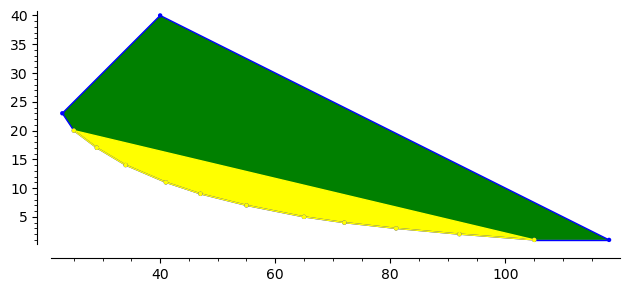

In [62]:
(Polyhedron(vertices=P16).plot()+Polyhedron(vertices=PointsPartages(16)).plot(color='yellow'))

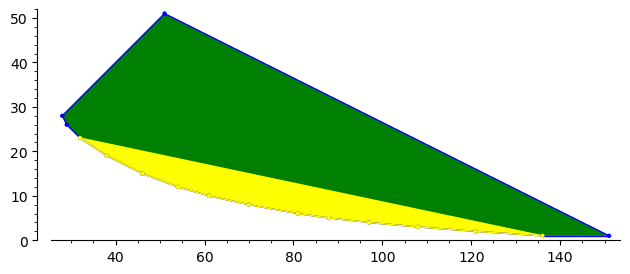

In [63]:
(Polyhedron(vertices=P18).plot()+Polyhedron(vertices=PointsPartages(18)).plot(color='yellow'))

In [64]:
PointsPartages(18)

{(136, 1), (108, 3), (38, 19), (97, 4), (61, 10), (32, 23), (54, 12), (81, 6), (121, 2), (70, 8), (88, 5), (46, 15)}

In [65]:
P18.difference(PointsPartages(18))

{(29, 26), (51, 51), (151, 1), (28, 28)}

In [66]:
A_mu((4,3,2,1))

s[10] + s[8, 1] + s[7, 1] + s[6, 2] + s[6, 1] + s[4, 3] + s[4, 2]

In [67]:
A_mu((3,2,2,1))

s[8] + s[6, 1] + s[5, 1] + s[4, 2]

In [68]:
def Eleve(f):
    return add(c*s(mu.Plus([1])) for mu,c in s(f))

def YT_cover(mu):
    mu=Partition(mu)
    return Set([mu.add_cell(c[1]-1,c[0]-1) for c in AddableCells(mu)])

In [69]:
table([[[(tau,mu),A_mu(mu)-Eleve(A_mu(tau))] 
        for mu in YT_cover(tau) if Is_Dominant(mu)] 
       for tau in Triangles(10,condition=Is_Dominant)])

[([], [1]), 0]
  [([1], [2]), 0]
  [([2], [3]), 0]
  [([2, 1], [3, 1]), 0]
  [([3], [3, 1]), s[2, 1]]
  [([3, 1], [3, 2]), 0]
  [([4], [4, 1]), s[3, 1]]
  [([3, 2], [3, 2, 1]), s[3, 1]]
  [([4, 1], [5, 1]), 0]
  [([5], [6]), 0]
  [([3, 2, 1], [4, 2, 1]), s[3, 2]]
  [([4, 2], [4, 2, 1]), s[4, 1]]
  [([5, 1], [6, 1]), 0]
  [([6], [6, 1]), s[5, 1]]
  [([4, 2, 1], [4, 3, 1]), 0]
  [([5, 2], [5, 3]), 0]
  [([6, 1], [6, 2]), s[4, 2]]
  [([7], [8]), 0]
  [([4, 3, 1], [4, 3, 2]), s[3, 3]]
  [([5, 3], [6, 3]), s[3, 3]]
  [([6, 2], [6, 3]), s[3, 3]]
  [([7, 1], [7, 2]), s[5, 2]]
  [([8], [9]), 0]
  [([4, 3, 2], [5, 3, 2]), s[5, 2]]
  [([5, 3, 1], [5, 3, 2]), s[4, 3]]
  [([6, 3], [6, 3, 1]), s[7, 1] + s[5, 2]]
  [([7, 2], [8, 2]), 0]
  [([8, 1], [8, 2]), s[6, 2]]
  [([9], [9, 1]), s[8, 1]]
  [([4, 3, 2, 1], [5, 3, 2, 1]), s[6, 2] + s[4, 3]]
  [([5, 3, 2], [5, 3, 2, 1]), s[7, 1] + s[5, 2] + s[4, 3]]
  [([6, 3, 1], [6, 4, 1]), 0]
  [([7, 3], [7, 4]), 0]
  [([8, 2], [8, 3]), s[5, 3]]
  [([9, 1], [10, 1]), 0]
  [([10], [11]), 0]

In [70]:
@cached_function
def A_mu(mu,n=None):
    mu=Partition(mu)
    if n==None:
        n=len(mu) 
    if n==len(mu) and not Is_Dominant(mu):
        return A_mu(Partition(mu).conjugate())
    else:
        return A_v(part_to_vect(mu,n))

def PoidArete(v,star=True):
    val=A_mu(topart(v[1]))-Eleve(A_mu(topart(v[0])))
    if val==0 or len(val)==1:
        return val
    if star:
        return ' '
    else:
        return val

def PoidArete(v,star=True):
    val=A_mu_norm((v[1]))-A_mu_norm((v[0]))
    if val==0 or len(val)==1:
        return val
    if star:
        return ' '
    else:
        return val

def tonum(mu):
    mu=Partition(mu)
    k=mu.length()
    return add(10^(k-i-1)*mu[i] for i in range(k))

def topart(num):
    return Partition([Integer(d) for d in str(num)])
    
@cached_function
def Young_Triangle_cond(n,condition=(lambda tau:True)):
    E=[tonum(nu) for k in range(n+1) for nu in TriangularPartitions(k) if condition(nu)]
    R=[(tonum(mu),tonum(nu)) for k in range(1,n+1) 
       for mu in TriangularPartitions(k-1) if condition(mu)
       for nu in TriangularPartitions(k) if condition(nu) and nu.contains(mu)]
    return Poset([E,R],cover_relations=True)

@cached_function
def Young_Triangle_cond(n,condition=(lambda tau:True)):
    E=[nu for k in range(n+1) for nu in TriangularPartitions(k) if condition(nu)]
    R=[(mu,nu) for k in range(1,n+1) 
       for mu in TriangularPartitions(k-1) if condition(mu)
       for nu in TriangularPartitions(k) if condition(nu) and nu.contains(mu)]
    return Poset([E,R],cover_relations=True)

@cached_function
def flip_norm(F,n=None):
    if n==None:
        n=F.degree()
    return F.scalar(Un)*s[n]+add(c*s([n-mu[0]]+mu[1:]) for mu,c in s(F) if mu.length()>0)

def A_norm(tau):
    return flip_norm(A(tau),add(tau))

def A_mu_norm(tau):
    return flip_norm(A_mu(tau),add(tau))

@cached_function
def SchurCat(n,flip=False):
    if flip:
        return flip_norm(SchurCat(n))
    else:
        return add(v[0]*s[SR(v[1]).degree(q)-1,SR(v[1]).degree(t)] 
               for v in (qt_catalan_number(n)*(q-t)).numerator() if v[0]>0)

@cached_function
def Comprime(Exp):
    return (Exp.scalar(Un)*Un + add(c*s(mu[1:]) for mu,c in s(Exp)(q*Z) if not mu.size()==0)).map_coefficients(to_qn)

In [71]:
YT=Young_Triangle_cond(11)
label={}
for v in YT.cover_relations():
    label[v[0],v[1]] =  PoidArete(v,star=True)
YT.plot(cover_labels=label,figsize=30).save('Dessin.pdf')

In [72]:
flip_norm(A_mu((5,4,3,2,1)),15)

s[] + s[2, 1] + s[3, 1] + s[4, 2] + s[4, 1] + s[5, 2] + s[6, 3] + s[5, 1] + s[6, 2] + s[7, 3] + s[8, 4] + s[7, 2] + s[8, 3] + s[9, 4] + s[8, 2] + s[9, 3] + s[11, 4]

In [73]:
rep=Qqt(expand(SR(mul(1/(1-q^i*t) for i in range(2,14))).series(q,15)).poly())

In [74]:
add(c*s([SR(mon).degree(q),SR(mon).degree(t)]) 
    for c,mon in Qqt(expand(rep)) 
    if SR(mon).degree(q)+SR(mon).degree(t)<16)-flip_norm(SchurCat(14)).restrict_degree(15,exact=False)

0

In [75]:
N=10
k=4
rep=Qqt(expand(SR(mul(1/(1-q^i*t) for i in range(2,N))).series(q,N+k)).poly())
add(c*s([SR(mon).degree(q),SR(mon).degree(t)]) 
    for c,mon in Qqt(expand(rep)) 
    if SR(mon).degree(q)+SR(mon).degree(t)<=N+k)-SchurCat(N,flip=True).restrict_degree(N+k,exact=False)

s[12, 2] + s[11, 2] + s[10, 2]

In [76]:
table([[n,Comprime(SchurCat(n,flip=True))] for n in range(1,9)])

\(1\),\(\boldsymbol{1}\)
\(2\),\(\boldsymbol{1}\)
\(3\),\(\boldsymbol{1} + q^{3} s_{1}\)
\(4\),\(\boldsymbol{1} + q^{3} q_{2} s_{1}\)
\(5\),\(\boldsymbol{1} + q^{3} q_{3} s_{1} + \frac{q^{6} q_{4}}{q_{2}} s_{2} + q^{9} s_{3}\)
\(6\),\(\boldsymbol{1} + q^{3} q_{4} s_{1} + q^{6} q_{5} s_{2} + q^{9} q_{4} s_{3} + \left({\left(q^{3} + q + 1\right)} q^{12}\right) s_{4}\)
\(7\),\(\boldsymbol{1} + q^{3} q_{5} s_{1} + \frac{q^{6} q_{3} q_{6}}{q_{2}} s_{2} + \frac{q^{9} q_{4} q_{5}}{q_{2}} s_{3} + \frac{q^{12} q_{4} q_{5}}{q_{2}} s_{4} + q^{15} q_{5} s_{5} + q^{18} q_{3} s_{6} + q^{21} s_{7}\)
\(8\),"\(\boldsymbol{1} + q^{3} q_{6} s_{1} + \frac{q^{6} q_{4} q_{7}}{q_{2}} s_{2} + \frac{q^{9} q_{4} q_{5} q_{6}}{q_{2} q_{3}} s_{3} + \left({\left(q^{4} + q^{3} + q^{2} + 1\right)} q^{12} q_{6}\right) s_{4} + \left({\left(q^{9} + q^{8} + 2 \, q^{7} + 3 \, q^{6} + 4 \, q^{5} + 3 \, q^{4} + 3 \, q^{3} + 2 \, q^{2} + q + 1\right)} q^{15}\right) s_{5} + \left({\left(q^{4} + q^{3} + q^{2} + 1\right)} q^{18} q_{4}\right) s_{6} + \left({\left(q^{7} + q^{6} + 2 \, q^{5} + 2 \, q^{4} + 3 \, q^{3} + 2 \, q^{2} + q + 1\right)} q^{21}\right) s_{7} + q^{24} q_{4} s_{8} + q^{27} s_{9}\)"
